# Sixth Classifier

No age or image data, since those seem to be the explanatory variables the classifiers love the most.
We also leave out counts of incalls, outcalls, or "incalls and outcalls".

## Imports

In [1]:
from itertools import chain
import html
import ujson as json
import multiprocessing as mp
import pickle
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold

from helpers import all_scoring_metrics
from helpers import draw_rocs

%matplotlib inline
sns.set(font='monospace')

num_folds = 10
eval_columns = ['f1',
                'accuracy',
                'true_negative_rate',
                'true_positive_rate',
                'roc_auc',
                'roc_fpr',
                'roc_tpr',
                'roc_thresholds']
price_cols = ['duration_in_mins',
              'price',
              'price_per_min']

In [2]:
df = pd.read_pickle('../../data/merged/data_to_use_by_phone_v4.pkl')
print(df.shape)
print(df['class'].value_counts())

(567, 150)
False    508
True      59
Name: class, dtype: int64


In [3]:
id_cols = {'class', 'phone'}
price_cols = {x for x in df.columns if x.find('price') > -1}
duration_cols = {x for x in df.columns if x.find('duration') > -1}
flag_cols = {x for x in df.columns if x.find('flag_') > -1}
ethnicity_cols = {x for x in df.columns if x.find('ethnicity_') > -1}
image_cols = {x for x in df.columns if x.find('image') > -1}
age_cols = {x for x in df.columns if x.find('age') > -1} | set(['flag_Juvenile'])
service_cols = set(['n_incall', 'n_outcall', 'n_incall_and_outcall'])

In [4]:
etc = ExtraTreesClassifier(oob_score=True,
                           bootstrap=True,
                           random_state=2,
                           n_estimators=100,
                           n_jobs=-1,
                           class_weight="balanced")

rf = RandomForestClassifier(oob_score=True,
                            random_state=2,
                            n_estimators=100,
                            n_jobs=-1,
                            class_weight="balanced")

## Execution
Use both Random Forests and Extra Trees to classify the data using all columns

In [5]:
y_series = df['class']
X_df = df.loc[:, sorted(set(df.columns) - id_cols - age_cols - image_cols - service_cols)]
print(y_series.shape)
print(X_df.shape)

(567,)
(567, 87)


### Extra Trees

In [6]:
etc_metrics = all_scoring_metrics(etc, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(etc_metrics.roc_auc.mean())
etc_metrics.loc[:, eval_columns]

0.6613202614379085


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.222222,0.877193,0.960784,0.166667,0.629085,"[0.0, 0.0392156862745, 0.117647058824, 0.11764...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.71, 0.636915099793, 0.34, 0.3, 0.19, 0.15, ..."
1,0.000000,0.807018,0.901961,0.000000,0.669935,"[0.0, 0.0980392156863, 0.0980392156863, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.3...","[1.64965161559, 0.649651615594, 0.48, 0.41, 0...."
2,0.133333,0.771930,0.843137,0.166667,0.388889,"[0.0, 0.137254901961, 0.196078431373, 0.235294...","[0.0, 0.166666666667, 0.166666666667, 0.166666...","[1.63460849754, 0.634608497544, 0.25, 0.24, 0...."
3,0.066667,0.508772,0.549020,0.166667,0.385621,"[0.0, 0.43137254902, 0.450980392157, 0.4509803...","[0.0, 0.166666666667, 0.166666666667, 0.5, 0.5...","[1.70661857164, 0.70661857164, 0.691568396466,..."
4,0.074074,0.561404,0.607843,0.166667,0.419935,"[0.0, 0.392156862745, 0.43137254902, 0.6078431...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.74, 0.712275959984, 0.24, 0.221849278589, 0..."
5,0.200000,0.859649,0.941176,0.166667,0.838235,"[0.0, 0.0588235294118, 0.0980392156863, 0.0980...","[0.166666666667, 0.166666666667, 0.16666666666...","[0.7, 0.645088546163, 0.449451913133, 0.37, 0...."
6,0.200000,0.859649,0.941176,0.166667,0.647059,"[0.0, 0.0392156862745, 0.0392156862745, 0.0784...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.5...","[1.64007053358, 0.640070533576, 0.57, 0.42, 0...."
7,0.222222,0.877193,0.960784,0.166667,0.694444,"[0.0, 0.0392156862745, 0.0392156862745, 0.0784...","[0.166666666667, 0.166666666667, 0.33333333333...","[0.78, 0.640254202141, 0.45, 0.33, 0.29, 0.26,..."
8,0.000000,0.875000,0.980000,0.000000,0.980000,"[0.0, 0.02, 0.02, 0.12, 0.16, 0.22, 0.28, 0.36...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.56, 0.56, 0.474783330496, 0.26, 0.25, 0.2, ..."
9,0.769231,0.945455,0.940000,1.000000,0.960000,"[0.0, 0.02, 0.06, 0.22, 0.26, 0.32, 0.36, 0.44...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.69, 0.69, 0.510457063565, 0.18, 0.17, 0.11,..."


In [7]:
etc_metrics.loc[:,  sorted(set(etc_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

n_ads                             0.094846
missing_price_per_min:count       0.072076
missing_duration_in_mins:count    0.069775
missing_price:count               0.069525
location_tree_length              0.056273
n_distinct_locations              0.053432
flag_Foreign Providers            0.049589
flag_Traveling                    0.042062
n_cooccurring_phones              0.038407
ethnicity_White                   0.034510
ethnicity_Ebony                   0.027606
ethnicity_Latina                  0.026567
ethnicity_Rican                   0.021659
ethnicity_Asian                   0.019235
ethnicity_Indian                  0.018438
flag_Multiple Girls               0.015130
ethnicity_Dominican               0.015021
missing_price:std                 0.015007
missing_duration_in_mins:std      0.014558
missing_price_per_min:std         0.013185
dtype: float64

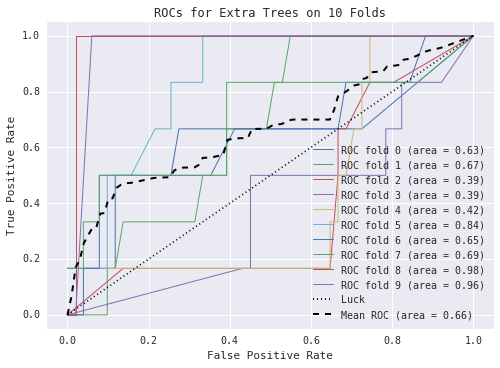

In [8]:
draw_rocs(etc_metrics, 'Extra Trees')

### Random Forest

In [9]:
rf_metrics = all_scoring_metrics(rf, X_df, y_series, StratifiedKFold(y_series, num_folds))
print(rf_metrics.roc_auc.mean())
rf_metrics.loc[:, eval_columns]

0.6387712418300653


,f1,accuracy,true_negative_rate,true_positive_rate,roc_auc,roc_fpr,roc_tpr,roc_thresholds
0,0.222222,0.877193,0.960784,0.166667,0.614379,"[0.0, 0.0392156862745, 0.0392156862745, 0.1176...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.5...","[1.63691509979, 0.636915099793, 0.62, 0.27, 0...."
1,0.000000,0.807018,0.901961,0.000000,0.635621,"[0.0, 0.0980392156863, 0.176470588235, 0.19607...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.64965161559, 0.649651615594, 0.34, 0.31, 0...."
2,0.133333,0.771930,0.843137,0.166667,0.421569,"[0.0, 0.137254901961, 0.254901960784, 0.294117...","[0.0, 0.166666666667, 0.166666666667, 0.166666...","[1.63460849754, 0.634608497544, 0.24184098848,..."
3,0.066667,0.508772,0.549020,0.166667,0.316993,"[0.0, 0.43137254902, 0.470588235294, 0.4705882...","[0.0, 0.166666666667, 0.166666666667, 0.333333...","[1.70661857164, 0.70661857164, 0.361140178106,..."
4,0.074074,0.561404,0.607843,0.166667,0.352941,"[0.0, 0.392156862745, 0.392156862745, 0.411764...","[0.0, 0.0, 0.166666666667, 0.166666666667, 0.1...","[1.71227595998, 0.712275959984, 0.55, 0.248447..."
5,0.000000,0.824561,0.921569,0.000000,0.805556,"[0.0, 0.0588235294118, 0.078431372549, 0.07843...","[0.0, 0.0, 0.0, 0.333333333333, 0.333333333333...","[1.64508854616, 0.645088546163, 0.53, 0.42, 0...."
6,0.000000,0.859649,0.960784,0.000000,0.632353,"[0.0, 0.0392156862745, 0.078431372549, 0.07843...","[0.0, 0.0, 0.0, 0.166666666667, 0.166666666667...","[1.64007053358, 0.640070533576, 0.44, 0.4, 0.2..."
7,0.222222,0.877193,0.960784,0.166667,0.668301,"[0.0, 0.0392156862745, 0.0392156862745, 0.0588...","[0.0, 0.0, 0.166666666667, 0.333333333333, 0.3...","[1.64025420214, 0.640254202141, 0.63, 0.38, 0...."
8,0.000000,0.892857,1.000000,0.000000,1.000000,"[0.0, 0.18, 0.24, 0.3, 0.38, 0.42, 0.46, 0.52,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.474783330496, 0.228962818004, 0.19298237162..."
9,0.714286,0.927273,0.920000,1.000000,0.940000,"[0.0, 0.02, 0.04, 0.08, 0.24, 0.3, 0.36, 0.42,...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.68, 0.68, 0.64, 0.510457063565, 0.17, 0.15,..."


In [10]:
rf_metrics.loc[:,  sorted(set(rf_metrics.columns) - set(eval_columns))].mean().sort_values(ascending=False).head(20)

missing_price:count               0.106343
n_ads                             0.103293
missing_price_per_min:count       0.094554
missing_duration_in_mins:count    0.090527
flag_Foreign Providers            0.058742
location_tree_length              0.055439
flag_Traveling                    0.045093
n_distinct_locations              0.042760
n_cooccurring_phones              0.041481
ethnicity_White                   0.030826
ethnicity_Latina                  0.024991
ethnicity_Ebony                   0.023360
flag_Multiple Girls               0.018092
ethnicity_Rican                   0.018017
ethnicity_Indian                  0.017519
missing_price:std                 0.016218
ethnicity_Asian                   0.015691
missing_duration_in_mins:std      0.012351
missing_price_per_min:std         0.011672
ethnicity_French                  0.011268
dtype: float64

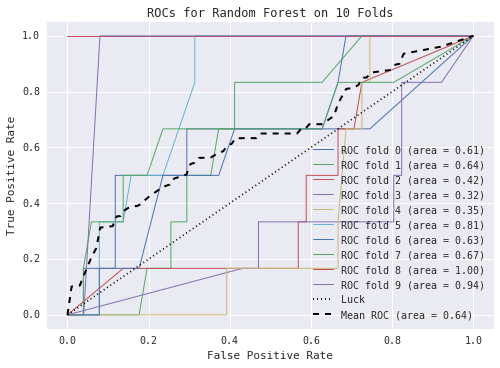

In [11]:
draw_rocs(rf_metrics, 'Random Forest')